In [19]:
import numpy as np
from matplotlib import pyplot as plt
import math
import planet_sampler_pop as ps
import pandas as pd
from scipy import stats  
import scipy.optimize as opt
%matplotlib inline

In [20]:
def snr_weiss(R_p, R_star, M_star, period, CDPP_6h):
    """
    snr_weiss : Computes the expected signal to noise ratio of a planet with size R_p and orbital period
    period orbiting a star with bulk density rho_star and radius R_star and a 6hr combined differential photometric precision 
    CDPP_6hr. This definition is taken from Weiss et al. 2018 https://iopscience.iop.org/article/10.3847/1538-3881/aa9ff6
    #####
    Parameters : 
    R_p : planet radius in Earth radius
    R_star : host star radius in solar radius
    M_star: host star mass in stellar mass
    period : period in days
    CDPP_6h : combined differential photometric precision over 6hr
    
    returns the value of SN ratio
    """
    R_sun = 695700
    R_earth = 6378
    M_sun = 1.989 * 10**30
    R_p_km = R_p * R_earth
    R_star_km = R_sun * R_star
    M_star_kg = M_star * M_sun
    rho_star = M_star/(R_star**3)
    depth = 1000000*(R_p_km / R_star_km)**2
    T = 13 * (period/365.24)**(1/3) * (rho_star)**(-1/3) # Parameter T in hours
    #print("period : " + str(period))
    #print("radius : " + str(R_p))
    #print("duration : " + str(T))
    #print("depth : " + str(depth))
    return  ((depth * math.sqrt(3.5 *365.24/ (period ))) / (CDPP_6h * math.sqrt(6/T)))


def swapping_criterion(R_p, R_star, M_star, period, CDPP_6h, snr_threshold = 10):
    return (snr_weiss(R_p, R_star, M_star, period, CDPP_6h) > snr_threshold)
    
    
def gaussian_fit(x, mu, sigma):
    return 1/math.sqrt(2*math.pi*sigma**2) * np.exp(-(x - mu)**2/(2*sigma**2))
def skew_gaus(x, mean, skew, sigma):
    return stats.skewnorm.pdf(x, skew, mean, sigma)

## Importing the data

In [21]:
original_planets = ps.PlanetSample("emile_testing_AG13_bright5_baseline.txt", dataset = "SAG")

life_planets = ps.PlanetSample("kerneltest_SAG13_bright5_weiss.txt", dataset = "SAG")
#life_planets = ps.PlanetSample("emile_testing_AG13_bright5_weiss.txt", dataset = "SAG")
#life_planets_500 = ps.PlanetSample("emile_testing_AG13_bright500_weiss.txt", dataset = "SAG")

## Trying to implement the same tests as Weiss et al. for original sample

In [22]:
Rps_plus = []
Rps_minus = []
nMC = 5
for i in range(nMC):    
    for snumber in range(326):
        a = original_planets.a[np.logical_and(original_planets.snumber == snumber, original_planets.nMC == i)]
        if(len(a) > 1):
            #print("Simulation " + str(i))
            Rps_temp = original_planets.Rp[np.logical_and(original_planets.snumber == snumber, original_planets.nMC == i)][a.argsort()]
            #as_temp = a[a.argsort()]
            Rps_temp_plus = Rps_temp[1:]
            Rps_temp_minus = Rps_temp[0:-1]
            Rps_plus.append(Rps_temp_plus)
            Rps_minus.append(Rps_temp_minus)
        else:
            pass
        #print("This system does not have enough planets in simulation " + str(i))
Rps_plus_kam = np.concatenate(np.array(Rps_plus))
Rps_minus_kam = np.concatenate(np.array(Rps_minus))

(0.012488217557158076, 0.47207663458614246)


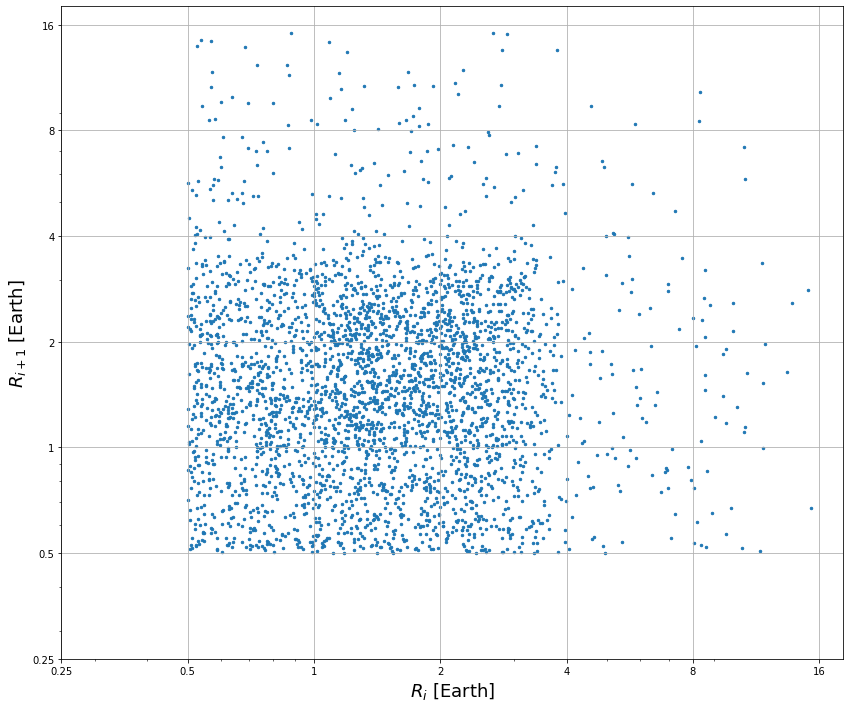

In [23]:
plt.figure(figsize = (14,12))
plt.scatter(Rps_minus_kam, Rps_plus_kam, s = 6, linewidth = 1)
plt.ylabel("$R_{i+1}$ [Earth]", fontsize = 18)
plt.xlabel("$R_{i}$ [Earth]", fontsize = 18)
plt.xscale("log")
plt.yscale("log")
plt.xticks([0.25,0.5,1,2,4,8,16], [0.25,0.5,1,2,4,8,16])
plt.yticks([0.25,0.5,1,2,4,8,16], [0.25,0.5,1,2,4,8,16])
plt.grid()
print(stats.pearsonr(Rps_minus_kam, Rps_plus_kam))

## For corrected sample ( nMC = 5)

In [7]:
print(max(life_planets.Rp))

20.89776


In [24]:
Rps_plus_life = []
Rps_minus_life = []
nMC = 5
for i in range(nMC):    
    for snumber in range(326):
        a = life_planets.a[np.logical_and(life_planets.snumber == snumber, life_planets.nMC == i)]
        if(len(a) > 1):
            #print("Simulation " + str(i))
            Rps_temp = life_planets.Rp[np.logical_and(life_planets.snumber == snumber, life_planets.nMC == i)][a.argsort()]
            #as_temp = a[a.argsort()]
            Rps_temp_plus = Rps_temp[1:]
            Rps_temp_minus = Rps_temp[0:-1]
            Rps_plus_life.append(Rps_temp_plus)
            Rps_minus_life.append(Rps_temp_minus)
        else:
            pass
        #print("This system does not have enough planets in simulation " + str(i))
Rps_plus_life = np.concatenate(np.array(Rps_plus_life))
Rps_minus_life = np.concatenate(np.array(Rps_minus_life))

(0.7736104036316301, 0.0)


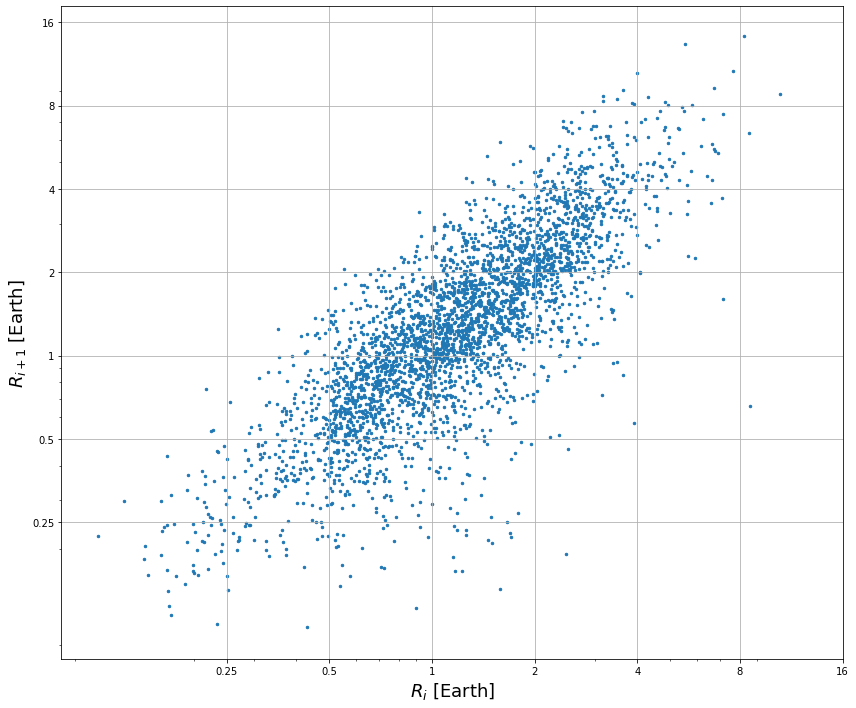

In [25]:
plt.figure(figsize = (14,12))
plt.scatter(Rps_minus_life, Rps_plus_life, s = 6, linewidth = 1)
plt.ylabel("$R_{i+1}$ [Earth]", fontsize = 18)
plt.xlabel("$R_{i}$ [Earth]", fontsize = 18)
plt.xscale("log")
plt.yscale("log")
plt.xticks([0.25,0.5,1,2,4,8,16], [0.25,0.5,1,2,4,8,16])
plt.yticks([0.25,0.5,1,2,4,8,16], [0.25,0.5,1,2,4,8,16])
plt.grid()
print(stats.pearsonr(Rps_minus_life, Rps_plus_life))

# For corrected sample (nMC = 500)

In [17]:
"""Rps_plus_life_ext = []
Rps_minus_life_ext = []
nMC = 500
for i in range(nMC):    
    print("Analyzing sim " + str(i) + " on " + str(nMC))
    for snumber in range(326):
        a = life_planets_500.a[np.logical_and(life_planets_500.snumber == snumber, life_planets_500.nMC == i)]
        if(len(a) > 1):
            #print("Simulation " + str(i))
            Rps_temp = life_planets_500.Rp[np.logical_and(life_planets_500.snumber == snumber, life_planets_500.nMC == i)][a.argsort()]
            #as_temp = a[a.argsort()]
            Rps_temp_plus = Rps_temp[1:]
            Rps_temp_minus = Rps_temp[0:-1]
            Rps_plus_life_ext.append(Rps_temp_plus)
            Rps_minus_life_ext.append(Rps_temp_minus)
        else:
            pass
        #print("This system does not have enough planets in simulation " + str(i))
Rps_plus_life_ext = np.concatenate(np.array(Rps_plus_life_ext))
Rps_minus_life_ext = np.concatenate(np.array(Rps_minus_life_ext))"""

'Rps_plus_life_ext = []\nRps_minus_life_ext = []\nnMC = 500\nfor i in range(nMC):    \n    print("Analyzing sim " + str(i) + " on " + str(nMC))\n    for snumber in range(326):\n        a = life_planets_500.a[np.logical_and(life_planets_500.snumber == snumber, life_planets_500.nMC == i)]\n        if(len(a) > 1):\n            #print("Simulation " + str(i))\n            Rps_temp = life_planets_500.Rp[np.logical_and(life_planets_500.snumber == snumber, life_planets_500.nMC == i)][a.argsort()]\n            #as_temp = a[a.argsort()]\n            Rps_temp_plus = Rps_temp[1:]\n            Rps_temp_minus = Rps_temp[0:-1]\n            Rps_plus_life_ext.append(Rps_temp_plus)\n            Rps_minus_life_ext.append(Rps_temp_minus)\n        else:\n            pass\n        #print("This system does not have enough planets in simulation " + str(i))\nRps_plus_life_ext = np.concatenate(np.array(Rps_plus_life_ext))\nRps_minus_life_ext = np.concatenate(np.array(Rps_minus_life_ext))'

In [18]:
plt.figure(figsize = (14,12))
plt.scatter(Rps_minus_life_ext, Rps_plus_life_ext, s = 6, linewidth = 1)
plt.ylabel("$R_{i+1}$ [Earth]", fontsize = 18)
plt.xlabel("$R_{i}$ [Earth]", fontsize = 18)
plt.xscale("log")
plt.yscale("log")
plt.xticks([0.25,0.5,1,2,4,8,16], [0.25,0.5,1,2,4,8,16])
plt.yticks([0.25,0.5,1,2,4,8,16], [0.25,0.5,1,2,4,8,16])
plt.grid()
print(stats.pearsonr(Rps_minus_life_ext, Rps_plus_life_ext))

NameError: name 'Rps_minus_life_ext' is not defined

<Figure size 1008x864 with 0 Axes>

### Trying to use Weiss' data to recreate their distribution

In [26]:
host_star = []
planet_radius = []
planet_period = []
star_mass = []
star_radius = []
CDPP_6h = []
with open("weiss_tables.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        host_star += [line[8:15]]
        planet_radius += [float(line[84:98])]
        planet_period += [float(line[69:82])]
        star_mass += [float(line[40:46])]
        star_radius += [float(line[47:52])]
        CDPP_6h += [float(line[53:60])]
host_star = np.array(host_star)
planet_radius = np.array(planet_radius)
planet_period = np.array(planet_period)
star_mass = np.array(star_mass)
star_radius = np.array(star_radius)
CDPP_6h = np.array(CDPP_6h)    

In [27]:
star_names = set(host_star)
count = 0
Rps_plus_weiss = []
Rps_minus_weiss = []
for star in star_names: # Loop on all the different stars 
    periods = planet_period[host_star == star]
    sorting = np.argsort(periods)
    periods = periods[sorting]
    radius_p = planet_radius[host_star == star][sorting]
    radius_star = star_radius[host_star == star][sorting]
    mass_star = star_mass[host_star == star][sorting]
    CDPP = CDPP_6h[host_star == star][sorting]
    if(len(periods) > 1): # If the star has a system with more than one planet
        for i in range(len(periods) - 1): # we loop over all the planet pairs of the system
            smallest_radius = min(radius_p[i], radius_p[i+1])
            largest_p = max(periods[i], periods[i+1])
            if(swapping_criterion(smallest_radius, radius_star[i], mass_star[i], largest_p,CDPP[i] , snr_threshold = 10)):
                Rps_temp = planet_radius[host_star == star][periods.argsort()]
                Rps_temp_plus = Rps_temp[i+1]
                Rps_temp_minus = Rps_temp[i]
                Rps_plus_weiss.append(Rps_temp_plus)
                Rps_minus_weiss.append(Rps_temp_minus)
            else:
                #print("The pair did not pass the swapping criterion")
                count += 1
            
    else:
        pass
Rps_plus_weiss = np.array(Rps_plus_weiss)
Rps_minus_weiss = np.array(Rps_minus_weiss)

print(count)

63


In [28]:
len(Rps_plus_weiss)

491

(0.37522182541352367, 7.322246788597882e-18)


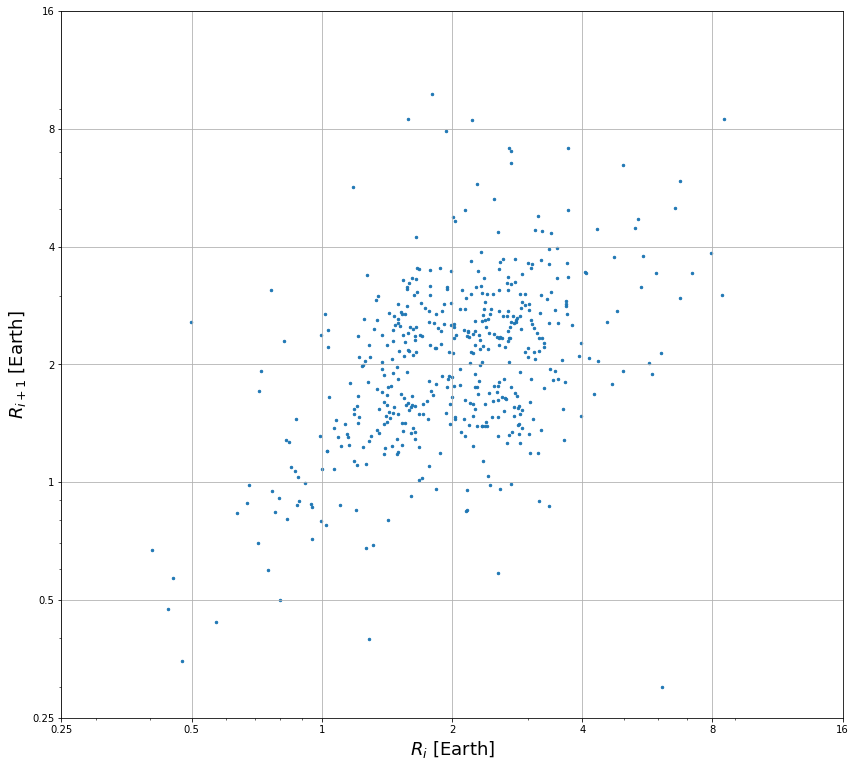

In [29]:
plt.figure(figsize = (14,13))
plt.scatter((Rps_minus_weiss), (Rps_plus_weiss), s = 6, linewidth = 1)
plt.ylabel("$R_{i+1}$ [Earth]", fontsize = 18)
plt.xlabel("$R_{i}$ [Earth]", fontsize = 18)
plt.xscale("log")
plt.yscale("log")
plt.xticks([0.25,0.5,1,2,4,8,16], [0.25,0.5,1,2,4,8,16])
plt.yticks([0.25,0.5,1,2,4,8,16], [0.25,0.5,1,2,4,8,16])
plt.grid()
print(stats.pearsonr(Rps_minus_weiss, Rps_plus_weiss))

## Comparing the 3 with an histogram

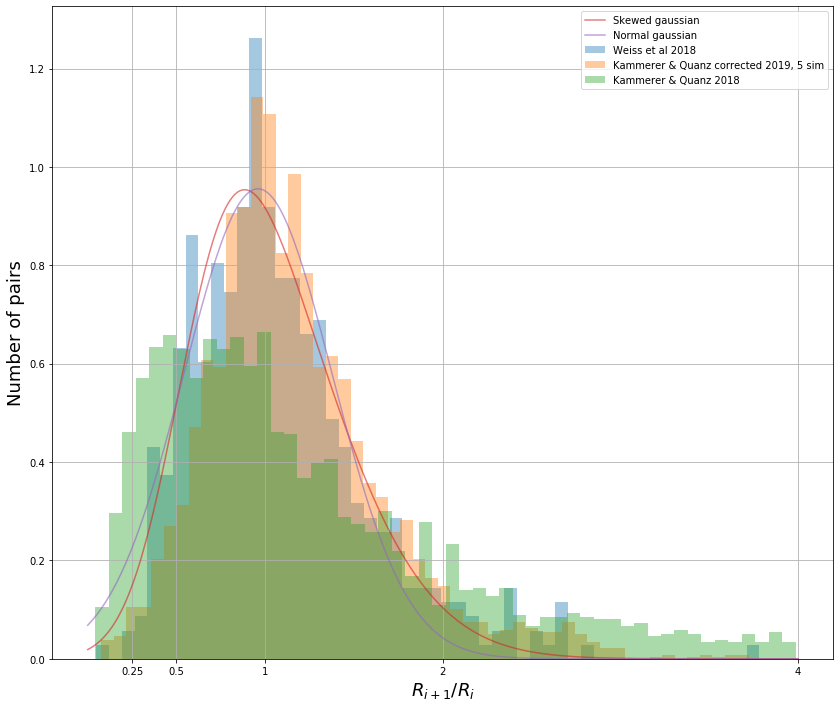

In [31]:
plt.figure(figsize = (14,12))
temp = (Rps_plus_weiss /Rps_minus_weiss) 
temp = temp[(temp < 4)]
temp_life = (Rps_plus_life / Rps_minus_life)
temp_life = temp_life[(temp_life < 4)]
#temp_life_ext = Rps_plus_life_ext / Rps_minus_life_ext
#temp_life_ext = temp_life_ext[(temp_life_ext < 4)]
temp_kam = Rps_plus_kam / Rps_minus_kam
temp_kam = temp_kam[(temp_kam < 4)]
entries, bin_edges, patches  =plt.hist(temp, bins = 52, density=True, alpha = 0.4, label = "Weiss et al 2018")
plt.hist(temp_life, bins = 52, density = True, alpha = 0.4, label = "Kammerer & Quanz corrected 2019, 5 sim")
#plt.hist(temp_life_ext, bins = 32, density = True, alpha = 0.4, label = "Kammerer & Quanz corrected 2019, 500 sim")
plt.hist(temp_kam, bins = 52, density = True, alpha = 0.4, label = "Kammerer & Quanz 2018")
x_plot = np.linspace(0,4, 300)
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
popt_gauss, pcov_gauss = opt.curve_fit(gaussian_fit, bin_middles,entries )
popt_skew, pcov_skew = opt.curve_fit(skew_gaus, bin_middles, entries, p0 = [1.1, 1, 3.5])
plt.plot(x_plot, skew_gaus(x_plot, popt_skew[0], popt_skew[1], popt_skew[2]), alpha = 0.6, label = "Skewed gaussian")
plt.plot(x_plot, gaussian_fit(x_plot, popt_gauss[0], popt_gauss[1]), alpha = 0.6, label = "Normal gaussian")
plt.xlabel("$R_{i+1} / R_i$", fontsize = 18)
plt.ylabel("Number of pairs", fontsize = 18)
plt.xticks([0.25,0.5,1,2,4], [0.25,0.5,1,2,4])
plt.grid()
plt.legend()

In [15]:
stats.ks_2samp(temp, temp_life)

Ks_2sampResult(statistic=0.1466939482175179, pvalue=2.1282813289502656e-08)

We see here that we get a p-value of 0.14, i.e the probability to get these results when assuming that the 2 datasets are generated by the same underlying dist is 14%. For the case of Kammerer & Quanz, we get a p-value of 10^⁻23. 

### Trying to see whether the radius dist is more likely to be coming from a gaussian or a skewed gaussian

In [16]:
print("Gaussian case : ")
stats.ks_2samp(temp, np.random.normal(loc = popt_gauss[0], scale = popt_gauss[1], size = 1000000))

Gaussian case : 


Ks_2sampResult(statistic=0.0798351855670103, pvalue=0.0041431332906554765)

In [17]:
print("Skewed gaussian case : ")
stats.ks_2samp(temp, stats.skewnorm(a = popt_skew[1], loc = popt_skew[0], scale = popt_skew[2]).rvs(1000000))

Skewed gaussian case : 


Ks_2sampResult(statistic=0.03754852577319584, pvalue=0.5013429385979874)

In [18]:
stats.ks_2samp(temp, temp_kam)

Ks_2sampResult(statistic=0.13051367904727593, pvalue=1.0736782097842124e-06)